In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
import glob
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [2]:
# folders = sorted(glob.glob("../India_95/complete/*"))
# images = []
# for folder in folders:
#     all_images = []
#     for i in os.listdir(folder):
#         path = os.path.join(folder,i)
#         all_images.append(path)
#     images.append([i for i in all_images if "forniceal_palpebral" in i][0])
# print(f"Total Number of Images = {len(images)}")

kobo_loc = "../testing/kobo_right_cutout.png"
camera_loc = "../testing/camera_right_cutout.png"

In [3]:
def mask(filename):
    input_image = Image.open(filename)
    input_image.load()
    image = Image.new("RGB", input_image.size, (255, 255, 255))
    image.paste(input_image, mask = input_image.split()[3])
    return np.array(image)

def canny_edge_detection(frame): 
    # Convert the frame to grayscale for edge detection 
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) 
        
    # Apply Gaussian blur to reduce noise and smoothen edges 
    # blurred = cv2.GaussianBlur(src=gray, ksize=(3, 5), sigmaX=0.5)  #CHANGE gray ---> blurred

    # Perform Canny edge detection 
    edges = cv2.Canny(gray, 70, 135)
      
    return edges

def get_contours(image,edges):

    # # define a (3, 3) structuring element
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # # apply the dilation operation to the edged image
    # dilate = cv2.dilate(edges, kernel, iterations=1) #CHANGE edge --> dilate

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours=sorted(contours, key=cv2.contourArea, reverse= True)
    
    image_copy = image.copy()
    
    # draw the contours on a copy of the original image
    cv2.drawContours(image_copy, sorted_contours, -1, (0, 255, 0), 2) 
    # print(len(contours), "object was found in this image.")

    return image_copy,contours

def crop(image,contours):
    c = max(contours, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    # cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0), 1)

    img_copy = image.copy()
    cropped_img=img_copy[y:y+h, x:x+w]

    return cropped_img

In [4]:
img1 = cv2.imread(kobo_loc)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
img2 = cv2.imread(camera_loc)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) 

Text(0.5, 1.0, 'Camera Image')

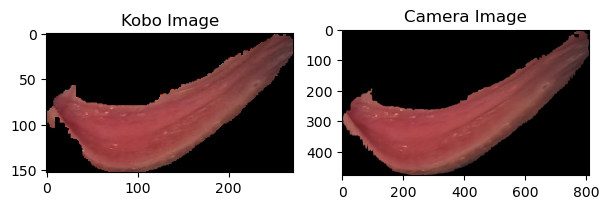

In [5]:
# create figure
fig = plt.figure(figsize=(7, 5))

# setting values to rows and column variables 
rows = 1
columns = 2

# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1)

# showing image 
plt.imshow(img1) 
# plt.axis('off') 
plt.title(f"Kobo Image")

# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(img2) 
# plt.axis('off') 
plt.title(f"Camera Image")

In [6]:
edges1 = canny_edge_detection(img1)
img_copy1,contours1 = get_contours(img1,edges1)
cropped_img1 = crop(img1,contours1) 

In [7]:
edges2 = canny_edge_detection(img2)
img_copy2,contours2 = get_contours(img2,edges2)
cropped_img2 = crop(img2,contours2) 

Text(0.5, 1.0, 'Cropped Image')

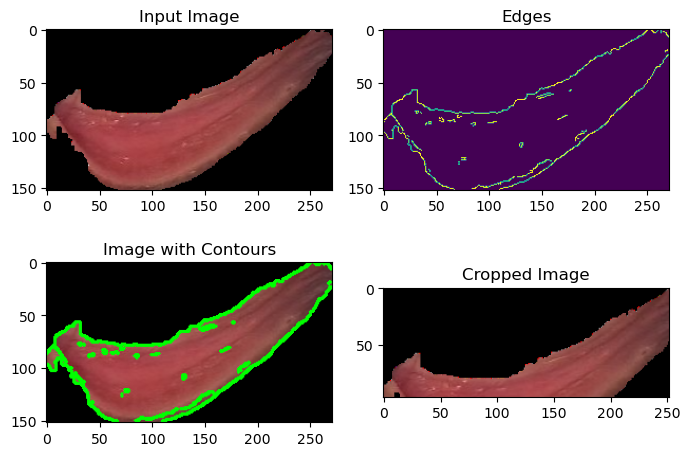

In [8]:
# create figure
fig = plt.figure(figsize=(7, 5))

# setting values to rows and column variables 
rows = 2
columns = 2

# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1)

# showing image 
plt.tight_layout()
plt.imshow(img1) 
# plt.axis('off') 
plt.title(f"Input Image")

# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2)

# showing image
plt.tight_layout() 
plt.imshow(edges1) 
# plt.axis('off') 
plt.title(f"Edges")

# Adds a subplot at the 3rd position 
fig.add_subplot(rows, columns, 3)

# showing image
plt.tight_layout() 
plt.imshow(img_copy1) 
# plt.axis('off') 
plt.title(f"Image with Contours")

# Adds a subplot at the 4th position 
fig.add_subplot(rows, columns, 4)

# showing image
plt.tight_layout() 
plt.imshow(cropped_img1) 
# plt.axis('off') 
plt.title(f"Cropped Image")

In [6]:
cropped_img_folder = []
for image in images:

    img = mask(image)
    edges = canny_edge_detection(img)
    img_copy,contours = get_contours(img,edges)
    cropped_img = crop(img,contours) 
    
    cropped_img_folder.append(cropped_img)

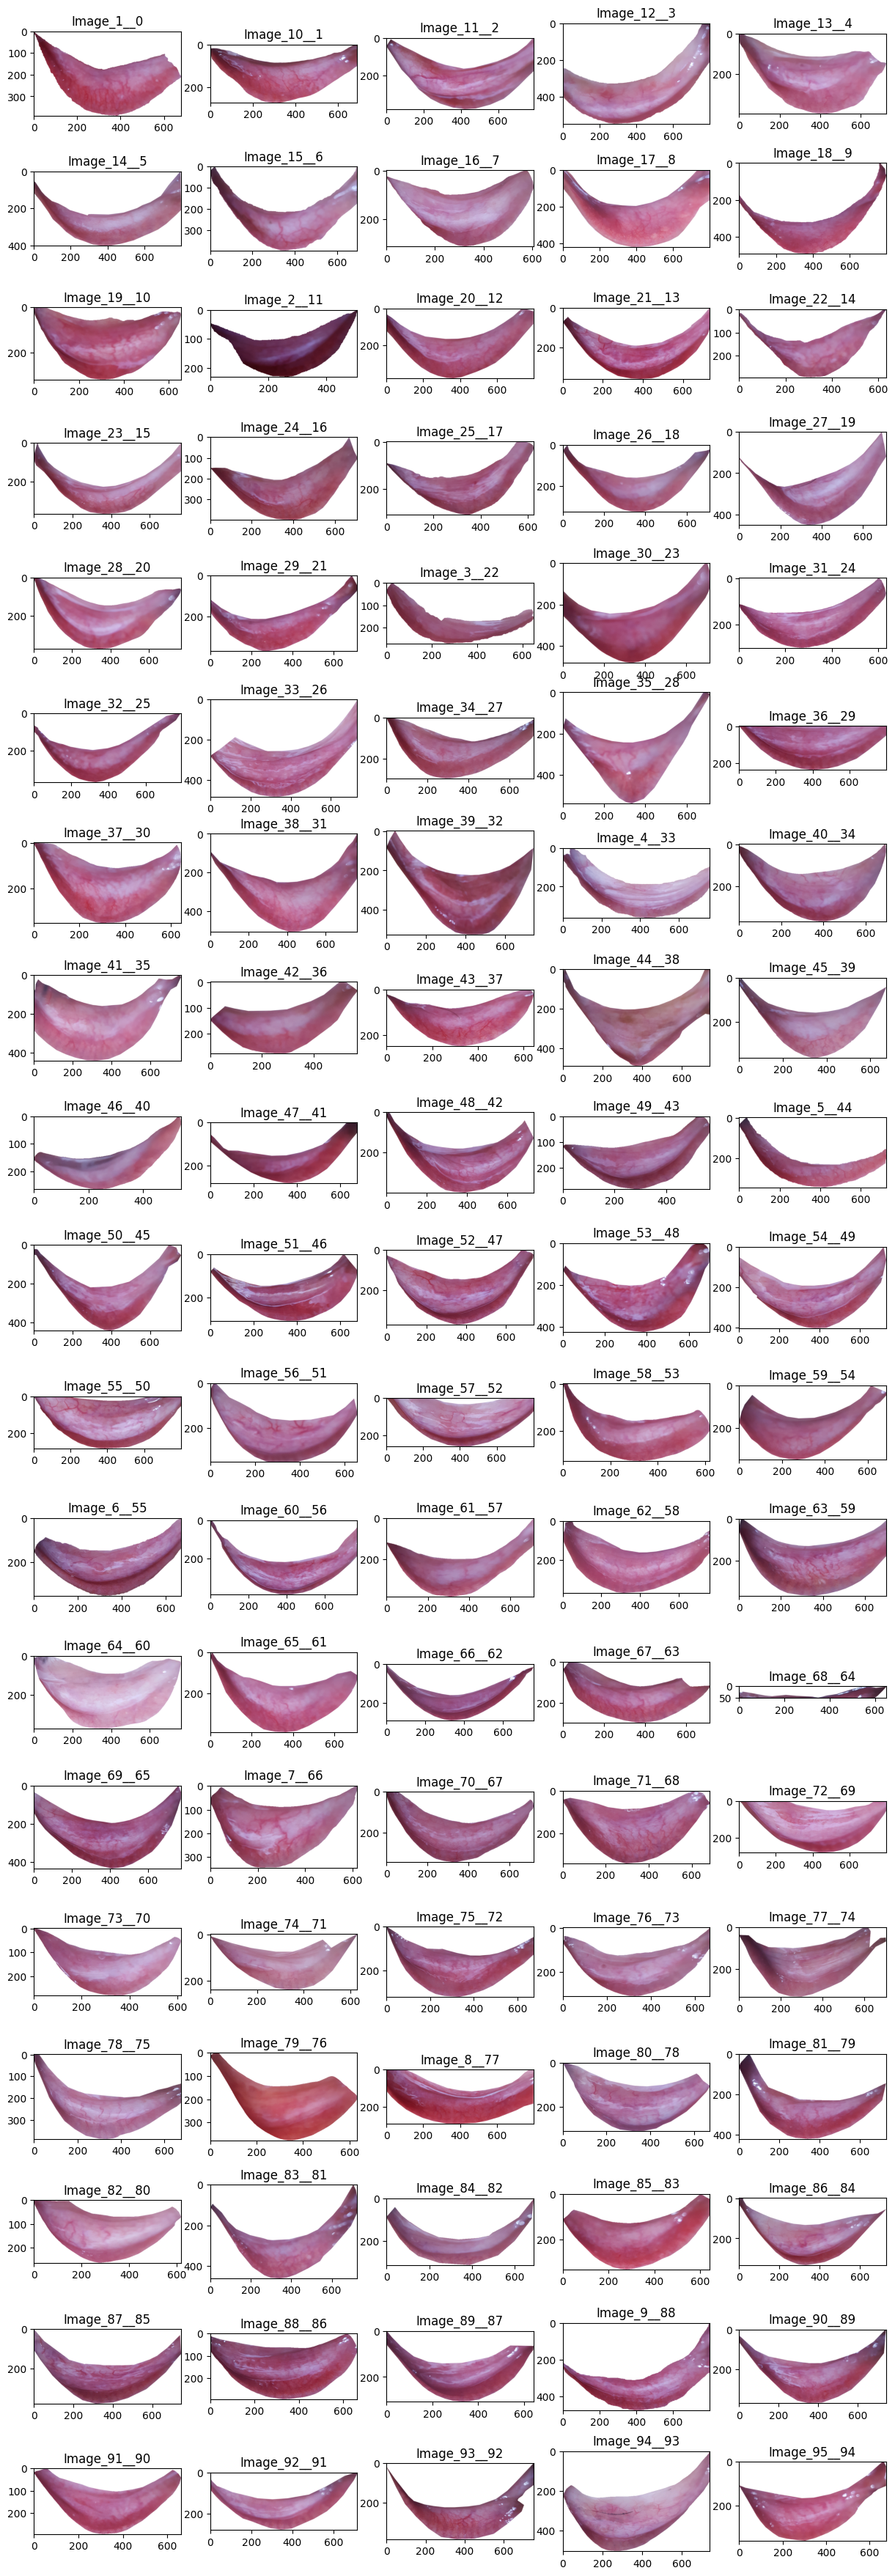

In [7]:
fig = plt.figure(figsize=(15, 45))
rows = 19
columns = 5

for i in range(1,len(cropped_img_folder)+1):

    number = images[i-1].split("/")[-2]

    fig.add_subplot(rows, columns, i)

    # showing image
    # plt.tight_layout() 
    plt.imshow(cropped_img_folder[i-1]) 
    # plt.axis('off') 
    plt.title(f"Image_{number}__{i-1}")

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

In [9]:
df = pd.read_excel("../India_95/India.xlsx",0)

In [10]:
from torchvision.models import resnet18, ResNet18_Weights

resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
# or any of these variants
# from torchvision.models import resnet34, ResNet34_Weights
# from torchvision.models import resnet50, ResNet50_Weights
# from torchvision.models import resnet101, ResNet101_Weights
# from torchvision.models import resnet152, ResNet152_Weights

modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)

resnet.eval()

def preprocess_image(img):

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return preprocess(img).unsqueeze(0)

In [11]:
All_Data = []
errors = []

for i in range(len(cropped_img_folder)):

    number = int(images[i].split("/")[-2])

    label = df.loc[df['Number'] == int(number)]['Hgb'].tolist()[0]

    try:
        input_batch = preprocess_image(Image.fromarray(np.uint8(cropped_img_folder[i])))

        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')
            resnet.to('cuda')

        with torch.no_grad():
            output = resnet(input_batch)

        # data = [number,label]
        output = output.cpu()
        data = output.squeeze().numpy()
        data = data.flatten().tolist()

        data.insert(0,number)
        data.append(label)

        All_Data.append(data)

    except Exception as e:
        error = [number,e]
        errors.append(error)

In [12]:
len(All_Data)

95

In [13]:
len(errors)

0

In [14]:
headers = ['number']
for i in range(512):
    col = 'data_' + str(i)
    headers.append(col)
headers.append('label')
df_save = pd.DataFrame(All_Data, columns=headers)
df_save.to_csv('../India_95/Data_new.csv', index=False)